# Bitwise Autoencoder

# Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt  
import tensorflow as tf

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Dense

# Predefined functions

In [21]:
def visualize (model, SNRs_db):
    K = model.K
    msg = np.arange(2**K)
    res = []
    for i in range(2**K):
        temp=msg[i]
        res_ = []
        for j in 2**np.linspace(K-1, 0, K):
            if temp - j >= 0 :
                res_.append(1)
                temp -= j
            else:
                res_.append(0)
        res.append(res_)
    bits = np.array(res, dtype=np.float32) 
    
    fig, axes = plt.subplots(1, len(SNRs_db), figsize=(len(SNRs_db)*7, 6))
    if len(SNRs_db) == 1 :
        axes = np.array([axes])
    for i in range(len(SNRs_db)):
                   
        llrs = model(bits, tf.ones(shape=(tf.shape(bits)[0], 1))*SNRs_db[i])
        x = model.x
        if tf.size(tf.shape(x)) == 1 :
            x = x[:, tf.newaxis]
                   
        axes[i].set_title('SNR_db = '+str(SNRs_db[i]))
        for j in range(2**K):
            axes[i].scatter(np.real(x[j, 0]), np.imag(x[j, 0]), s=100)
            axes[i].set_xlim([-1.65, 1.65])
            axes[i].set_ylim([-1.65, 1.65])

In [22]:
def evaluate_rate(model, SNRs_eval, DS_size=10240):
    
    print('K = '+str(model.K))
    
    DS_bits, DS_SNRs = gen_DS(DS_size, model.K, 1., 1.)
    TF_DS_test = tf.data.Dataset.from_tensor_slices((DS_bits, DS_SNRs)).shuffle(DS_size).batch(1024)
    
    print("SNR (dB) = ", end='')
    rates = []
    for snr_i in SNRs_eval :

        rates_temp = []
        for step, (bits, SNRs) in enumerate(TF_DS_test):
            pb_eq_1 = model(bits, SNRs*snr_i)
            err_loss =  tf.reduce_mean(tf.keras.losses.binary_crossentropy(bits, pb_eq_1))
            rates_temp.append(model.K-err_loss.numpy())
        rates.append(np.mean(rates_temp))
        print(str(snr_i)+', ', end='')
    print('')
    return rates

In [5]:
def gen_DS(DS_size, K, SNR_db_low, SNR_db_high):
 
    DS_bits = tf.random.uniform(shape=[DS_size, K], minval=0, maxval=2, dtype=tf.int32)
    DS_SNRs = tf.random.uniform(shape=[DS_size, 1], minval=SNR_db_low, maxval=SNR_db_high)
    return tf.cast(DS_bits, tf.float32), DS_SNRs

# AWGN Channel

In [28]:
class Channel(Layer):

    def __init__(self, **kwargs):
        super(Channel, self).__init__(**kwargs)           
    def call(self, x, SNR_db):        
        noise_std = tf.sqrt( 1 / tf.pow(10., SNR_db/10.0))
        noise_r = tf.random.normal(shape = [tf.shape(x)[0], 1], stddev = 1) * noise_std/tf.sqrt(2.)
        noise_i = tf.random.normal(shape = [tf.shape(x)[0], 1], stddev = 1) * noise_std/tf.sqrt(2.)
        return x + tf.complex(noise_r, noise_i)

# Autoencoder Model

### 1. Define Autoencoder model

In [15]:
class Autoencoder(Model):

    def __init__(self, K, **kwargs):
        super(Autoencoder, self).__init__(**kwargs)
        
        self.K = K
        self.powtwo = tf.constant([float(tf.pow(2, i)) for i in range(self.K)])
        
        self.tx_layer_1 = Dense(128, activation='relu') 
        self.tx_layer_2 = Dense(128, activation='relu') 
        self.tx_layer_3 = Dense(128, activation='relu') 
        self.tx_layer_4 = Dense(128, activation='relu') 
        self.tx_layer_5 = Dense(128, activation='relu') 
        self.tx_layer_6 = Dense(2 * tf.pow(2, K)) 
        
        self.channel = Channel() 
        
        self.rx_layer_1 = Dense(128, activation='relu') 
        self.rx_layer_2 = Dense(128, activation='relu') 
        self.rx_layer_3 = Dense(128, activation='relu') 
        self.rx_layer_4 = Dense(128, activation='relu') 
        self.rx_layer_5 = Dense(128, activation='relu') 
        self.rx_layer_6 = Dense(self.K, activation='sigmoid') 
    
    def call(self, bits, SNR_db):        
        ### Encoder
        self.x = SNR_db
        self.x = self.tx_layer_1(self.x)
        self.x = self.tx_layer_2(self.x)
        self.x = self.tx_layer_3(self.x)
        self.x = self.tx_layer_4(self.x)
        self.x = self.tx_layer_5(self.x)
        self.x = self.tx_layer_6(self.x)
        self.x = tf.complex(self.x[:,:(tf.pow(2,K))], self.x[:,(tf.pow(2,K)):])

        ### Normalization & Channel
        bit = tf.math.reduce_sum(bits * self.powtwo, 1)
        bit = tf.cast(bit, tf.int32)
        bit = tf.one_hot(bit, tf.pow(2, K))
        self.energy = tf.reduce_mean(tf.square(tf.abs(self.x)), axis=1, keepdims=True)
        self.x = self.x/tf.cast(tf.sqrt(self.energy),tf.complex64)
        self.x = tf.reduce_sum(tf.math.multiply(self.x, tf.cast(bit,tf.complex64)), axis=1, keepdims=True)
        
        self.y = self.channel(self.x, SNR_db)
        self.yc = tf.concat([tf.math.real(self.y), tf.math.imag(self.y)], axis=1)
        
        ### Receiver
        self.y = tf.concat([SNR_db, self.yc], axis=1)
        self.y = self.rx_layer_1(self.y)
        self.y = self.rx_layer_2(self.y)
        self.y = self.rx_layer_3(self.y)
        self.y = self.rx_layer_4(self.y)
        self.y = self.rx_layer_5(self.y)
        self.pb = self.rx_layer_6(self.y)
        
        return self.pb

### 2 -  Instantiate the model, the loss, and the optimizer

In [16]:
K = 4

# Instantiate an autoencoder
autoencoder = Autoencoder(K)

#Initialize optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) # Optimizer
loss_func = tf.keras.losses.BinaryCrossentropy() # Loss function

### 3 - generate and create optimized Tensorflow datasets

In [17]:
DS_size_train = 100000+352
DS_size_test = 1000

batch_size = 1024
DS_bits, DS_SNRs_db = gen_DS(DS_size_train+DS_size_test+24, K, SNR_db_low=-5, SNR_db_high=30)
print('Dataset generated with K =', K)
TF_DS_train = tf.data.Dataset.from_tensor_slices((DS_bits[:DS_size_train], DS_SNRs_db[:DS_size_train])).shuffle(10000).batch(batch_size)
TF_DS_test = tf.data.Dataset.from_tensor_slices((DS_bits[DS_size_train:], DS_SNRs_db[DS_size_train:])).batch(batch_size)


Dataset generated with K = 4


### 4 - Train the model


In [18]:
### Training loop 
nb_epoch = 30

print('Loss after each epoch:')

for epoch in range(nb_epoch):
    
    # Iterate over the batches of the dataset.
    for step, (DS_bits, DS_SNRs_db) in enumerate(TF_DS_train):
        # print("DS_SNRs_db size = ", DS_SNRs_db.shape)
        
        # Open a GradientTape.
        with tf.GradientTape() as tape:

            # Forward pass.
            probas = autoencoder(DS_bits, DS_SNRs_db)

            # Loss value for this batch.
            loss_value = loss_func(y_true=DS_bits, y_pred=probas)

        # Get gradients of loss wrt the weights.
        gradients = tape.gradient(loss_value, autoencoder.trainable_weights)

        # Update the weights of our linear layer.
        optimizer.apply_gradients(zip(gradients, autoencoder.trainable_weights))
    
    #Test the model on the test datasets
    test_loss = 0.
    for step, (DS_bits, DS_SNRs_db) in enumerate(TF_DS_test):
        probas = autoencoder(DS_bits, DS_SNRs_db)
        test_loss += loss_func(y_true=DS_bits, y_pred=probas)
    print((test_loss/(step+1)).numpy(), end=', ')
print('Done')

Loss after each epoch:
0.589051, 0.41748828, 0.3923183, 0.37660277, 0.3380716, 0.29445857, 0.25941473, 0.24180242, 0.2374564, 0.22810134, 0.20396677, 0.20484404, 0.22254667, 0.21040282, 0.2016527, 0.20309141, 0.19186632, 0.1979613, 0.19741394, 0.19443755, 0.19068995, 0.1854867, 0.18767655, 0.1861771, 0.19545613, 0.20823014, 0.19139694, 0.1867503, 0.18738425, 0.1979741, Done


### 5 - Evaluate the model

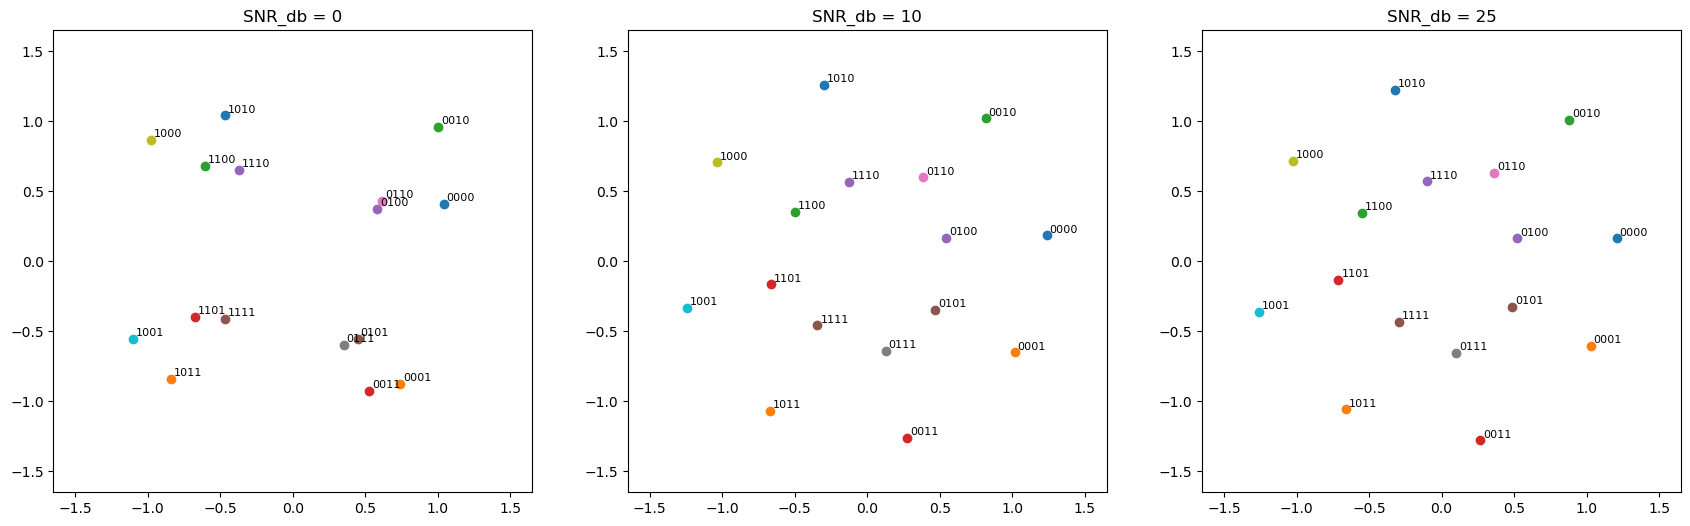

In [23]:
visualize(autoencoder, SNRs_db=[0, 10, 25])

In [25]:
snr_range = np.arange(0, 30)
results=[]
bs_eval = 1000000

for eval_snr in snr_range:
    batch_bits = tf.random.uniform(shape=[bs_eval, K], minval=0, maxval=2, dtype=tf.int32)
    batch_snr = eval_snr*tf.ones(shape=[bs_eval, 1])
       
    
    p_b = autoencoder(tf.cast(batch_bits, tf.float32), tf.cast(batch_snr, tf.float32))
    # rot = autoencoder2.yc
    # matplotlib.pyplot.scatter((rot[:, 0]), (rot[:, 0]))
    b_hat = tf.cast(tf.sign(p_b-0.5)/2+1, dtype=tf.int32)
    ber = tf.reduce_sum(tf.abs(b_hat - batch_bits))/(bs_eval*K)
    results.append(ber.numpy())
    print(eval_snr, end=', ')
print("BER = np.array(", results, end=') ')

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, BER = np.array( [0.29728825, 0.2693855, 0.2418215, 0.2160345, 0.191, 0.1667015, 0.14274325, 0.120013, 0.09852825, 0.078941, 0.0613385, 0.0460825, 0.0333185, 0.02281625, 0.01487075, 0.008843, 0.00490075, 0.00244525, 0.00104975, 0.000416, 0.0001305, 3.775e-05, 8e-06, 7.5e-07, 2.5e-07, 0.0, 0.0, 0.0, 0.0, 0.0]) 

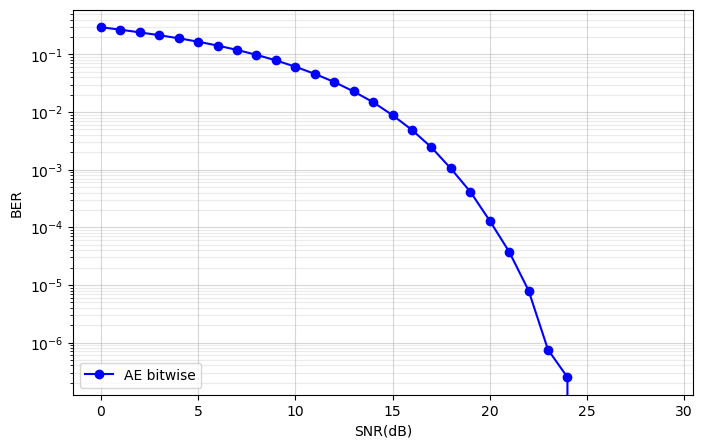

In [27]:
# plot
plt.figure(figsize=(8, 5))
plt.semilogy(snr_range, results, 'bo-', label='AE bitwise')
plt.xlabel('SNR(dB)')
plt.ylabel('BER');
plt.legend(loc='lower left')
plt.grid(which='major', alpha=0.5)
plt.grid(which='minor', alpha=0.25)